## Algorithm for efficient vector overlay of a polygon representation over a regular grid

* [Environment settings](#Settings): for the notebook to run...
* [Dummy proxy datasets](#Datasets): we prepare some "proxy" data for testing, you can skip this section...but you will still have to run it if you want to test the final algorithm (see below).
* Vector layers overlay: [Workable solution](#Solution): what needs to be done conceptually. 
* Vector layers overlay: [Practical implementation](#Implementation): what needs to be done in practice owing to computational limitations. You can skip this part.
* **Vector layers overlay: [Summary - Algorithm](#Algorithm): a stepwise summary of the tiled overlay algorithm**. Follow this link to retrieve the final algorithm.
* Alternative solution: [Rasterisation](#Rasterisation): ignore.

### Settings<a id='Settings'></a>

All you need... The first packages here are 

In [1]:
_THISDIR_ = !pwd 
_THISDIR_ = _THISDIR_[0]

import os, sys
import requests
import warnings
import time

import numpy as np
import pandas as pd

In [2]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
finally:
    _FIGSIZE_, _DPI_ = (10,8), 140 
%matplotlib inline

For the rest, I use the *Python* libraries [`shapely`](https://shapely.readthedocs.io/en/latest/manual.html) and [`geopandas`](https://geopandas.org) because it implements essential components:
* basic [set](https://geopandas.org/set_operations.html) and [geometric](https://geopandas.org/geometric_manipulations.html) operations, and
* [spatial indexing](https://geopandas.org/mergingdata.html?highlight=spatial%20index) through the [R-Tree algorithm](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html). 

These implementations are not optimal in the sense that they are wrappers to the [GEOS library](https://trac.osgeo.org/geos/), itself a port of the Java Topology Suite ([JTS](https://projects.eclipse.org/projects/locationtech.jts)), similarly to what is used in QGis. 

For an implmentation in *R*, the [sf](https://r-spatial.github.io/sf/) library, for instance, provide with similar processing capabilities.  

In [3]:
try:
    import shapely
except ImportError:
    try:
        !{sys.executable} -m pip install shapely
    except:
        print("! Error !")
else:
    from shapely import geometry 
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Error !")

We will also need the library for parallel multiprocessing (actually...not exactly):

In [4]:
import multiprocessing as mp
from queue import Empty

Looking at the same area:

In [5]:
class Test(): # class used to avoid confusion with the final algorithm
    COUNTRY = {'BE': 'Belgium'}

### Dummy proxy datasets (skip!) <a id='Datasets'></a>

Don't pay much attention to this section. We just download some 'proxy' data:
* NUTS regions at level 3, that will be regarded as the non-ovelapping poygonal representation (likewise Proximus data),
* the boundaries of BE area.

and I will create another vector layer:
* regular grid over that same area.

Let's fetch/retrieve the data, first the NUTS regions:

In [6]:
Test.IPROJ = '3035' # that's LAEA, but whatever works... we can still (re)project

Test.FMT = 'geojson'
Test.RES = 20
gisco_domain = 'https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download'
gisco_rest = 'https://gisco-services.ec.europa.eu/distribution/v2'

ctry_domain = 'countries'
Test.CTRY_YEAR = 2020

ctry_name = '{}-region-%sm-%s-%s.%s' % (Test.RES, Test.IPROJ, Test.CTRY_YEAR, Test.FMT)
ctry_site = '%s/%s/%s-%s-units.html' % (gisco_rest, ctry_domain, ctry_domain, Test.CTRY_YEAR)
ctry_file = '%s/%s/%s/%s' % (gisco_rest, ctry_domain, 'distribution', ctry_name)

In [7]:
ctry_file = ctry_file.format(next(iter(Test.COUNTRY.keys())))
ctry_name = ctry_name.format(next(iter(Test.COUNTRY.keys())))

try:
    print("Fetching data: %s" % ctry_file)
    resp = requests.get(ctry_file)
    resp.raise_for_status()
except:
    raise IOError("Error fetching data...")
else:
    !wget -O $ctry_name "$ctry_file"
    print('Country data (= dissolved representation) loaded on disk: \033[1m%s\033[0m' % os.path.join(_THISDIR_, ctry_name))

Fetching data: https://gisco-services.ec.europa.eu/distribution/v2/countries/distribution/BE-region-20m-3035-2020.geojson
--2020-05-21 03:32:00--  https://gisco-services.ec.europa.eu/distribution/v2/countries/distribution/BE-region-20m-3035-2020.geojson
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.93.170
Connecting to gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)|40.113.93.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1902 (1.9K)
Saving to: ‘BE-region-20m-3035-2020.geojson’

BE-region-20m-3035- 100%[===================>]   1.86K  --.-KB/s    in 0s      

2020-05-21 03:32:00 (46.5 MB/s) - ‘BE-region-20m-3035-2020.geojson’ saved [1902/1902]

Country data (= dissolved representation) loaded on disk: /Users/gjacopo/Developments/bodylanguage/BE-region-20m-3035-2020.geojson


then the region border:

In [8]:
border = gpd.read_file(os.path.join(_THISDIR_,ctry_name), driver='GeoJSON')
print("Projection system") 
border.crs

Projection system


<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

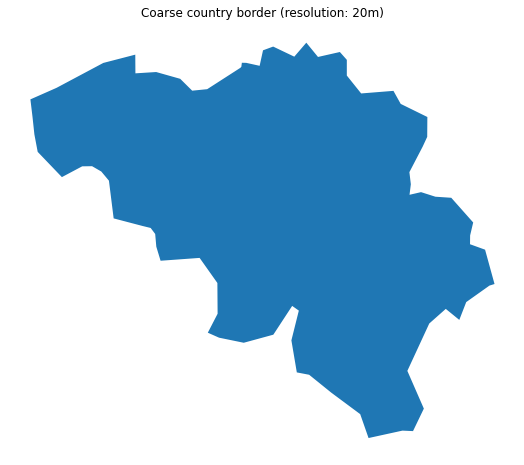

In [9]:
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
border.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Coarse country border (resolution: %sm)' % Test.RES)
mplt.show()

In [10]:
nuts_domain = 'nuts'
Test.NUTS_YEAR = 2021
Test.LEVEL = 3

nuts_name = 'NUTS_RG_%sM_%s_%s_LEVL_%s.%s' % (Test.RES,  Test.NUTS_YEAR, Test.IPROJ, Test.LEVEL,  Test.FMT)
nuts_site = '%s/%s/%s-%s-units.html' % (gisco_rest, nuts_domain, nuts_domain,  Test.NUTS_YEAR)
nuts_file = '%s/%s/%s/%s' % (gisco_rest, nuts_domain, Test.FMT, nuts_name)

In [11]:
try:
    print("Fetching data: %s" % nuts_file)
    resp = requests.get(nuts_file)
    resp.raise_for_status()
except:
    raise IOError("Error fetching data...")
else:
    !wget -O $nuts_name "$nuts_file"
    print('Reginal data (= polygon representation) loaded on disk: \033[1m%s\033[0m' % os.path.join(_THISDIR_,nuts_name))

Fetching data: https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3035_LEVL_3.geojson
--2020-05-21 03:32:02--  https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3035_LEVL_3.geojson
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.93.170
Connecting to gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)|40.113.93.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 955102 (933K)
Saving to: ‘NUTS_RG_20M_2021_3035_LEVL_3.geojson’

NUTS_RG_20M_2021_30 100%[===================>] 932.72K  1.54MB/s    in 0.6s    

2020-05-21 03:32:03 (1.54 MB/s) - ‘NUTS_RG_20M_2021_3035_LEVL_3.geojson’ saved [955102/955102]

Reginal data (= polygon representation) loaded on disk: /Users/gjacopo/Developments/bodylanguage/NUTS_RG_20M_2021_3035_LEVL_3.geojson


In [12]:
polygons = gpd.read_file(os.path.join(_THISDIR_, nuts_name), driver='GeoJSON')
print("Projection system:")
polygons.crs

Projection system:


<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
polygons = polygons.loc[polygons.FID.apply(lambda x: x.startswith(next(iter(Test.COUNTRY.keys()))))] 
polygons.head(5)

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
321,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3,None,"POLYGON ((3918540.000 3093738.000, 3919617.000..."
322,BE211,None,None,Arr. Antwerpen,BE,BE211,BE211,Arr. Antwerpen,3,None,"POLYGON ((3950634.000 3159703.000, 3955443.000..."
323,BE212,None,None,Arr. Mechelen,BE,BE212,BE212,Arr. Mechelen,3,None,"POLYGON ((3955879.000 3116089.000, 3937267.000..."
324,BE213,None,None,Arr. Turnhout,BE,BE213,BE213,Arr. Turnhout,3,None,"POLYGON ((3980659.000 3157888.000, 3980658.000..."
325,BE224,None,None,Arr. Hasselt,BE,BE224,BE224,Arr. Hasselt,3,None,"POLYGON ((4013903.000 3107852.000, 4011003.000..."


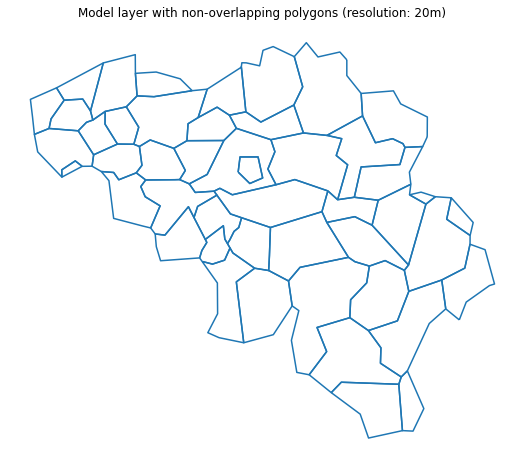

In [14]:
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
polygons.boundary.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Model layer with non-overlapping polygons (resolution: %sm)' % Test.RES)
mplt.show()

Given the polygonal representation, define a regular grid over the bounding box (considering coordinates in LAEA are expressed in m):

In [15]:
xmin, ymin, xmax, ymax = bounds = polygons.total_bounds
print("Bounding box coordinates: Xmin=%s, Ymin=%s, Xmax=%s, Ymax=%s" % (xmin,ymin,xmax,ymax))
print("------------ extent: X: %sm (%skm) -- Y: %sm (%skm)" % 
      (xmax-xmin, round((xmax-xmin)/1000), ymax-ymin, round((ymax-ymin)/1000)))

Bounding box coordinates: Xmin=3799789.0, Ymin=2941705.0, Xmax=4065087.0, Ymax=3167694.0
------------ extent: X: 265298.0m (265.0km) -- Y: 225989.0m (226.0km)


Say we are interested in a grid of 125m x 125m. We can create the grid programmatically, also adding a buffer (some issue apparently with the `total_bounds` estimation). For this example, we simplify the calculation to a 10km x 10km grid:

Grid series shape: (725, 1)
Grid actual shape: (25, 29)


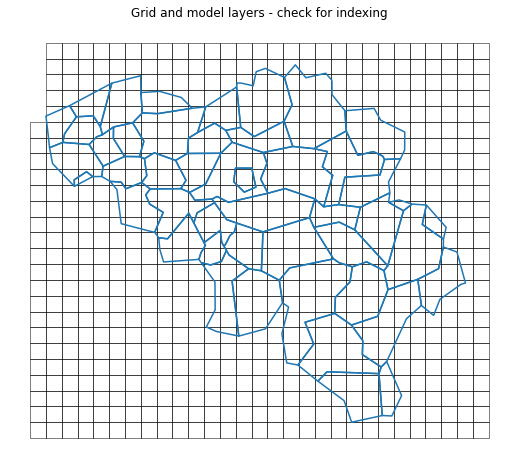

In [16]:
def get_grid_shape(cls, gridsize, bounds, buffer=0):    
    # return the dimension of the grid, i.e. the number of cell rows and columns
    buffer = gridsize if buffer is True else (0 if buffer in (False,None) else buffer)
    xmin, ymin, xmax, ymax = bounds
    nrows = abs(int(np.ceil((ymax-ymin+2*buffer) / gridsize))) 
    ncols = abs(int(np.ceil((xmax-xmin+2*buffer) / gridsize))) 
    return nrows, ncols
Test.get_grid_shape = classmethod(get_grid_shape)

def get_grid_cells(cls, width, height, bounds, buffer=0):   
    # return the (x,y) positions of the intersections (vertices) of the regular grid 
    buffer = gridsize if buffer is True else (0 if buffer in (False,None) else buffer)
    xmin, ymin, xmax, ymax = bounds
    cols = list(range(int(np.floor(xmin - buffer)), int(np.ceil(xmax + buffer)), width))
    rows = list(range(int(np.floor(ymin - buffer)), int(np.ceil(ymax + buffer)), height))
    rows.reverse()
    return cols, rows
Test.get_grid_cells = classmethod(get_grid_cells)

def build_regular_grid(cls, gridsize, bounds, buffer=None, crs=None):
    # build a regular grid in a reference system that preserves area
    buffer = gridsize if buffer is True else (0 if buffer in (False,None) else buffer)
    width = height = gridsize
    cols, rows = cls.get_grid_cells(width, height, bounds, buffer) 
    polygrid = []
    [polygrid.append(geometry.Polygon([(x,y+height), (x+width,y+height), (x+width,y), (x,y)])) 
         for x in cols for y in rows] # note the order: cols then rows
    grid = gpd.GeoDataFrame({'geometry':polygrid})
    if crs is not None:
        grid.crs = crs
    return grid
Test.build_regular_grid = classmethod(build_regular_grid)

Test.BUFFER = True
Test.GRIDSIZE = 10 * 1000
%timeit 
grid = Test.build_regular_grid(Test.GRIDSIZE, 
                               [xmin, ymin, xmax, ymax], 
                               buffer = Test.BUFFER, 
                               crs = polygons.crs)

print('Grid series shape:', grid.shape)
print('Grid actual shape:', Test.get_grid_shape(Test.GRIDSIZE, 
                                                [xmin, ymin, xmax, ymax], 
                                                Test.BUFFER))

f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
grid.geometry[5:len(grid)].boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
polygons.boundary.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Grid and model layers - check for indexing')
mplt.show()

Consider however the use of the [GridMaker](https://github.com/eurostat/GridMaker) for this exercise. 

In real use-case, layers A and B are actually defined in different reference systems. Let's change the reference system of layer B and consider the projected dataset as the input for the problem:

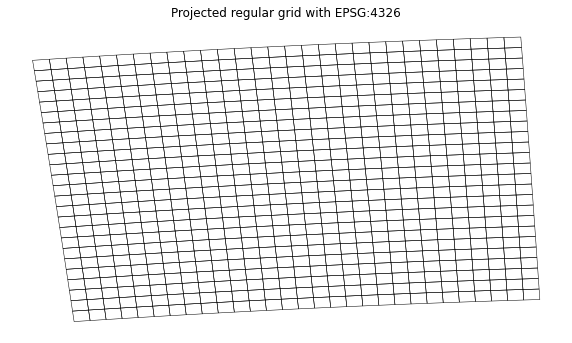

In [17]:
Test.OPROJ = 4326
grid = grid.to_crs("EPSG:%s" % Test.OPROJ)

f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
grid.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.set_axis_off(); ax.set_title('Projected regular grid with EPSG:%s' % Test.OPROJ)
mplt.show()

Following, let's also project the model layer A (polygon representation) into the output reference system of the regular grid: 

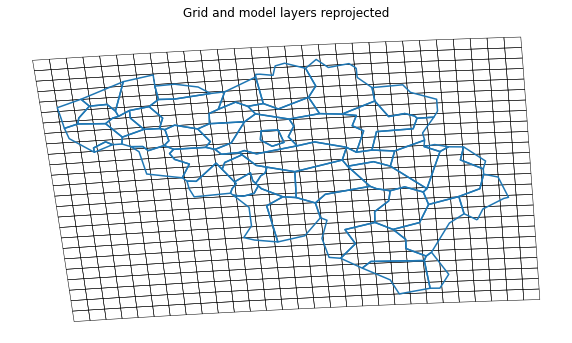

In [18]:
polygons = polygons.to_crs(grid.crs)

f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
grid.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
polygons.boundary.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Grid and model layers reprojected')
mplt.show()

### Vector layers overlay: Workable solution<a id='Solution'></a>

Say we have two vector layers "like" above:
* a non-overlapping (multi)polygonal representation 'A' (the Voronoi tesselation of the real use-case),
* a regular grid 'B' (the INSPIRE grid in real use-case),

available over the same area, at different resolutions and in different projections. 

Ultimately, we want to calculate the proportion of area of the polygons layer A that lie within the grid layer B. To do so, we will overlay the model layer A onto the grid layer B.

Conceptually, the set operation that is requested here is "union", not "intersection" (*cf.* Albrecht and Janine's approach; see for instance [overlay page in QGis](https://docs.qgis.org/3.10/en/docs/user_manual/processing_algs/qgis/vectoroverlay.html)). Because the model layer A is fully covered by the grid layer B, both set operations will produce the same topology (same polygons) in the inner part of A.  

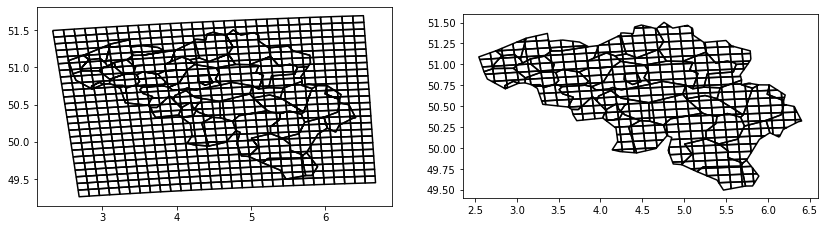

In [19]:
f, ax = mplt.subplots(1,2, figsize=(14,10))

#%timeit 
poly_union = gpd.overlay(polygons, grid, how='union')
poly_union.boundary.plot(edgecolor='k', ax=ax[0]);

#%timeit 
poly_inter = gpd.overlay(polygons, grid, how='intersection')
poly_inter.boundary.plot(edgecolor='k', ax=ax[1]);

However, they may result in different geometries. Using "union", we are ensured to create (multi)polygons only (as a union of polygons in the input layers, while intersection may result in the creation of lines features for instance. In addition, the entire grid is represented.

What we have to do is simply:
* compute the area of each polygon in the model layer A (using the area units of the output projection of B) and store it as an attribute `poly_area` in the table,
* run the "union" overlay operation of model layer A and grid layer B,
* calculate the percentage of overlap in the output union layer compared to the entire area of the model layer as the ratio `(uarea/poly_area)`, where `uarea` is the area of the newly created vector featues:

In [20]:
Test.COL_POLY_AREA = 'poly_area'

polygons[Test.COL_POLY_AREA] = polygons.area
polygons.head(5)

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,poly_area
321,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3,None,"POLYGON ((4.28309 50.81361, 4.28882 50.89180, ...",0.020273
322,BE211,None,None,Arr. Antwerpen,BE,BE211,BE211,Arr. Antwerpen,3,None,"POLYGON ((4.66955 51.42638, 4.75626 51.27510, ...",0.134720
323,BE212,None,None,Arr. Mechelen,BE,BE212,BE212,Arr. Mechelen,3,None,"POLYGON ((4.78932 51.03893, 4.52867 50.99226, ...",0.058768
324,BE213,None,None,Arr. Turnhout,BE,BE213,BE213,Arr. Turnhout,3,None,"POLYGON ((5.10218 51.42900, 5.11079 51.34848, ...",0.185360
325,BE224,None,None,Arr. Hasselt,BE,BE224,BE224,Arr. Hasselt,3,None,"POLYGON ((5.62239 50.99924, 5.58953 50.90961, ...",0.111912


In [21]:
Test.COL_UNION_AREA = 'uarea'

poly_union = gpd.overlay(polygons, grid, how='union')
poly_union[Test.COL_UNION_AREA] = poly_union.area
poly_union.head(5)

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,poly_area,geometry,uarea
0,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3.0,None,0.020273,"POLYGON ((4.44717 50.78055, 4.38437 50.75975, ...",0.003368
1,BE241,None,None,Arr. Halle-Vilvoorde,BE,BE241,BE241,Arr. Halle-Vilvoorde,3.0,None,0.124554,"POLYGON ((4.45260 50.73496, 4.31382 50.70755, ...",0.007790
2,BE310,None,None,Arr. Nivelles,BE,BE310,BE310,Arr. Nivelles,3.0,None,0.138130,"POLYGON ((4.31382 50.70755, 4.45260 50.73496, ...",0.001580
3,BE100,None,None,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,BE,BE100,BE100,Arr. de Bruxelles-Capitale/Arr. Brussel-Hoofdstad,3.0,None,0.020273,"POLYGON ((4.47953 50.80484, 4.48508 50.79310, ...",0.000656
4,BE241,None,None,Arr. Halle-Vilvoorde,BE,BE241,BE241,Arr. Halle-Vilvoorde,3.0,None,0.124554,"POLYGON ((4.55354 50.80836, 4.59060 50.77038, ...",0.006928


In [22]:
Test.COL_PCT_AREA = 'pct_area'

poly_union[Test.COL_PCT_AREA] = 100 * poly_union[Test.COL_UNION_AREA].div(poly_union[Test.COL_POLY_AREA])
poly_union = poly_union[['id', 'NUTS_ID', Test.COL_PCT_AREA, 'geometry']]
poly_union.head(5)

,id,NUTS_ID,pct_area,geometry
0,BE100,BE100,16.612181,"POLYGON ((4.44717 50.78055, 4.38437 50.75975, ..."
1,BE241,BE241,6.254650,"POLYGON ((4.45260 50.73496, 4.31382 50.70755, ..."
2,BE310,BE310,1.144159,"POLYGON ((4.31382 50.70755, 4.45260 50.73496, ..."
3,BE100,BE100,3.236319,"POLYGON ((4.47953 50.80484, 4.48508 50.79310, ..."
4,BE241,BE241,5.562247,"POLYGON ((4.55354 50.80836, 4.59060 50.77038, ..."


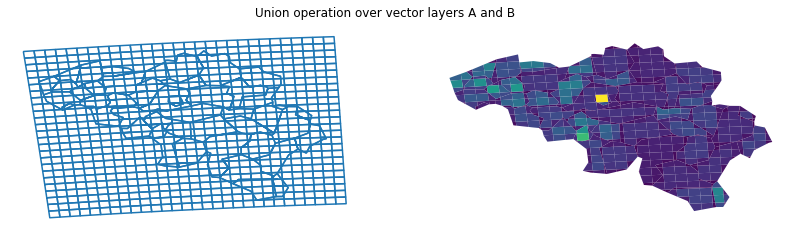

In [23]:
f, ax = mplt.subplots(1,2, figsize=(14,10))
f.suptitle("Union operation over vector layers A and B"); f.subplots_adjust(top=+1.5)
#f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
poly_union.boundary.plot(ax=ax[0])
poly_union.plot(column=Test.COL_PCT_AREA, legend=False, ax=ax[1])  
#               legend_kwds={'label': "%age of coverage by model layer", 'orientation': "horizontal"})
ax[0].set_axis_off(); ax[1].set_axis_off()

### Vector layers overlay: Practical implementation<a id='Implementation'></a>

Considering the actual sizes (numbers of vector features) of the model and grid layers A and B in real use-case, it is not possible to run practically the above operations (*cf.* Albrecht and Janine's approach: 1 week processing in QGis). 

Instead, we propose the following approach:
* **split both layers into tiles,** 
* **perform the "union" set operation for the tiles,** 
* **merge the results.** 

Given the know size of the cells in the regular grid (`gridsize`), say we know we have to limit calculations to tiles with 5 x 5 cells maximum (*e.g.* because this is a critical limit):

In [24]:
def get_tiles_cells(cls, nlimit, gridsize, bounds, buffer=0):  
    return cls.get_grid_cells(nlimit * gridsize, bounds, buffer=buffer)
Test.get_tiles_cells = classmethod(get_tiles_cells) 

def define_tiles_as_grid(cls, nlimit, gridsize, bounds, buffer=None, crs=None): 
    # simply refurbhish the function used to build the regular grid...
    print("! consider defining the tile by union instead !")
    return cls.build_regular_grid(nlimit * gridsize, bounds, buffer=buffer, crs = crs)
Test.define_tiles_as_grid = classmethod(define_tiles_as_grid)

Test.NLIMIT = 5
tiles = Test.define_tiles_as_grid(Test.NLIMIT, 
                                  Test.GRIDSIZE, 
                                  [xmin, ymin, xmax, ymax], 
                                  buffer = Test.GRIDSIZE, 
                                  crs = "EPSG:%s" % Test.IPROJ) 

tiles = tiles.to_crs("EPSG:%s" % Test.OPROJ)
tiles.head(5)

! consider defining the tile by union instead !


,geometry
0,"POLYGON ((2.33476 51.49473, 3.05203 51.53965, ..."
1,"POLYGON ((2.40920 51.04813, 3.11962 51.09255, ..."
2,"POLYGON ((2.48189 50.60142, 3.18561 50.64535, ..."
3,"POLYGON ((2.55287 50.15459, 3.25006 50.19805, ..."
4,"POLYGON ((2.62221 49.70764, 3.31300 49.75064, ..."


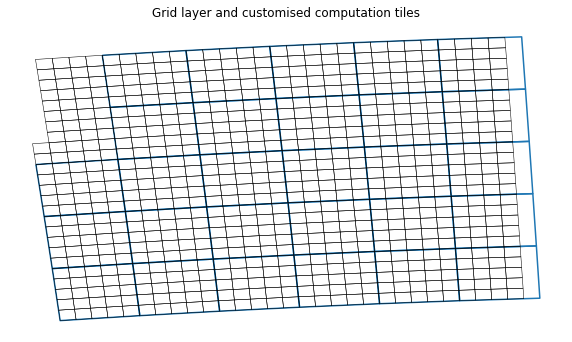

In [25]:
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
tiles[2:].boundary.plot(ax=ax)
grid[8:].boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.set_axis_off(); ax.set_title('Grid layer and customised computation tiles')
mplt.show()

Another way to build the tiling consists in merging (dissolving) the grid cells according to the desired pattern:

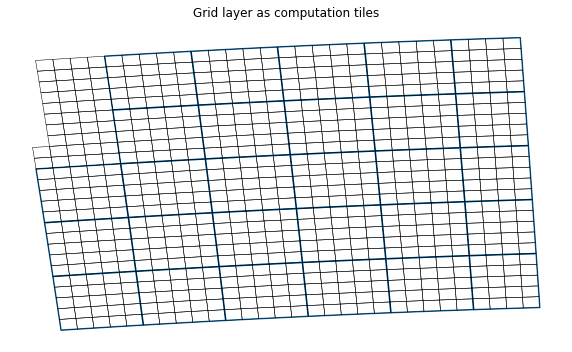

In [26]:
def get_tile_shape(cls, nlimit, gridsize, bounds, buffer=0):
    buffer = gridsize if buffer is True else (0 if buffer in (False,None) else buffer)
    xmin, ymin, xmax, ymax = bounds
    nxtiles = abs(int(np.ceil((xmax-xmin+2*buffer) / (nlimit*gridsize))))  # cols
    nytiles = abs(int(np.ceil((ymax-ymin+2*buffer) / (nlimit*gridsize))))  # rows
    return nytiles, nxtiles 
Test.get_tile_shape = classmethod(get_tile_shape)

def get_tile_grid_items(cls, x, y, nrows, ncols, nlimit):
    lenght = nrows*ncols -1
    index = [(x*nlimit+i)*nrows + (y*nlimit + j) for j in range(nlimit) for i in range(nlimit)]
    return [ind for ind in index if ind<=lenght]
Test.get_tile_grid_items = classmethod(get_tile_grid_items)

def define_tiles_as_union(cls, grid, nlimit, gridsize, bounds, buffer=None): 
    buffer = gridsize if buffer is True else (0 if buffer in (False,None) else buffer)
    nytiles, nxtiles = cls.get_tile_shape(nlimit, gridsize, bounds, buffer)
    nrows, ncols = cls.get_grid_shape(gridsize, bounds, buffer) 
    polytiles = []
    [polytiles.append(grid.iloc[cls.get_tile_grid_items(x, y, nrows, ncols, nlimit)].unary_union) 
                     for x in range(nxtiles) for y in range(nytiles)] 
    tiles = gpd.GeoDataFrame({'geometry':polytiles})
    if grid.crs is not None:
        tiles.crs = grid.crs
    return tiles
Test.define_tiles_as_union = classmethod(define_tiles_as_union)

utiles = Test.define_tiles_as_union(grid, 
                                    Test.NLIMIT, 
                                    Test.GRIDSIZE, 
                                    [xmin, ymin, xmax, ymax], 
                                    Test.BUFFER) 
utiles = utiles.to_crs("EPSG:%s" % Test.OPROJ)

f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
utiles[2:].boundary.plot(ax=ax)
grid[8:].boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.set_axis_off(); ax.set_title('Grid layer as computation tiles')
mplt.show()

Let's define once for all (*i.e.* as global parameters) the dimension of the grid layer and the tiles. For each tile, we can retrieve the bounds that we will use to filter (clip) the vector layers A and B:

In [27]:
print(Test.GRIDSIZE, [xmin, ymin, xmax, ymax], Test.BUFFER)
nrows, ncols = Test.get_grid_shape(Test.GRIDSIZE, [xmin, ymin, xmax, ymax], Test.BUFFER)   
print('Grid actual shape:', (nrows, ncols))
nytiles, nxtiles = Test.get_tile_shape(Test.NLIMIT, Test.GRIDSIZE, [xmin, ymin, xmax, ymax], Test.BUFFER)
print('Tile actual shape:', (nytiles, nxtiles))
ntiles = len(tiles)

utiles.bounds.head(5)

10000 [3799789.0, 2941705.0, 4065087.0, 3167694.0] True
Grid actual shape: (25, 29)
Tile actual shape: (5, 6)


,minx,miny,maxx,maxy
0,2.334756,51.048128,3.119625,51.539649
1,2.409202,50.601416,3.185614,51.092549
2,2.481888,50.154590,3.250056,50.645350
3,2.552872,49.707644,3.313001,50.198049
4,2.622212,49.260573,3.374500,49.750638


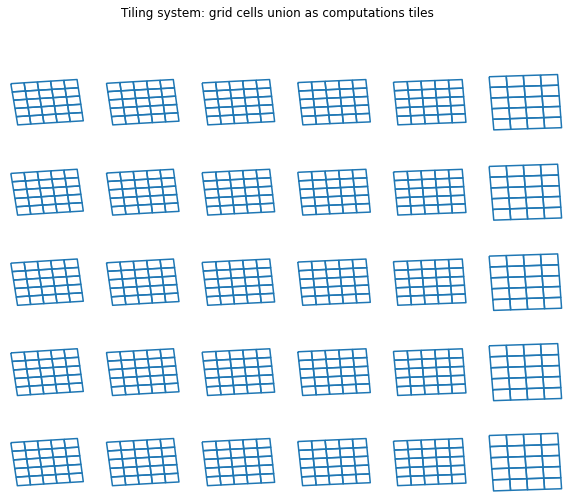

Content of the subgrids: ['geometry']


In [28]:
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

def clip_by_bound(cls, index, grid, tiles):
    # clip by bounding box
    mask = gpd.GeoDataFrame([1], geometry=[tiles.geometry[index]], crs=tiles.crs)
    return gpd.clip(grid, mask, keep_geom_type=True)
Test.clip_by_bound = classmethod(clip_by_bound)

def filter_by_bound(cls, index, grid, tiles):
    # filter grid using bounding box
    print("! consider filter by clipping instead !")
    xmin, ymin, xmax, ymax = tiles.bounds.loc[index,:].tolist()
    return grid.cx[xmin:xmax, ymin:ymax] # problem: returns those that intersect
Test.filter_by_bound = classmethod(filter_by_bound)

f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)
f.suptitle('Tiling system: grid cells union as computations tiles')
for y in range(nytiles):
    for x in range(nxtiles):
        index = x*nytiles + y
        if False: 
            small_grid = Test.filter_by_bound(index, grid, utiles)
        else:     
            small_grid = Test.clip_by_bound(index, grid, utiles)
        small_grid.boundary.plot(ax=ax[y,x])
        ax[y,x].set_axis_off() 
mplt.show()

print('Content of the subgrids: \033[1m%s\033[0m' % list(small_grid.columns))

Let's see the "interesection" overlay operation between a tile and the polygon

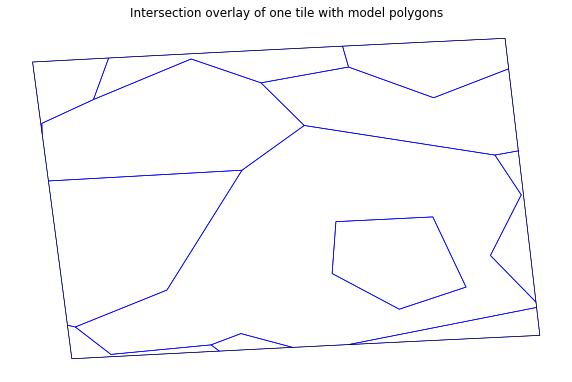

Content of the intersection polygons: ['id', 'COAST_TYPE', 'MOUNT_TYPE', 'NAME_LATN', 'CNTR_CODE', 'FID', 'NUTS_ID', 'NUTS_NAME', 'LEVL_CODE', 'URBN_TYPE', 'poly_area', 0, 'geometry']


In [29]:
Test.RANDINDEXTILE = 11
geom = utiles.geometry[Test.RANDINDEXTILE]
onetile = gpd.GeoDataFrame([1], geometry=[geom], crs=utiles.crs)

inter = gpd.overlay(polygons, onetile, how='intersection')
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
inter.boundary.plot(ax=ax, edgecolor='b', linewidth=0.7)
onetile.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
ax.set_axis_off(); ax.set_title('Intersection overlay of one tile with model polygons')
mplt.show()

print('Content of the intersection polygons: \033[1m%s\033[0m' % list(inter.columns))

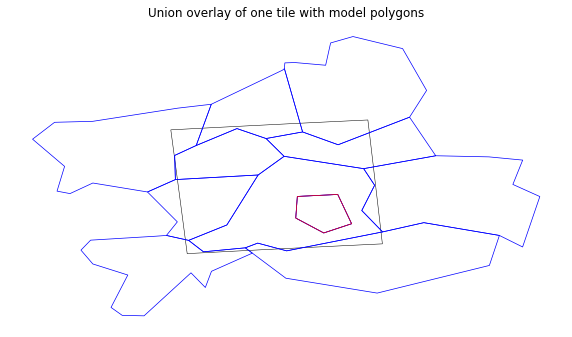

Content of the intersecting polygons: ['id', 'COAST_TYPE', 'MOUNT_TYPE', 'NAME_LATN', 'CNTR_CODE', 'FID', 'NUTS_ID', 'NUTS_NAME', 'LEVL_CODE', 'URBN_TYPE', 'geometry', 'poly_area']


In [30]:
def intersects_tile(cls, polygon, tile):
    return polygon.loc[polygon.intersects(tile)]
Test.intersects_tile = classmethod(intersects_tile)

def within_tile(cls, polygon, tile):
    return polygon.loc[polygon.within(tile)]
Test.within_tile = classmethod(within_tile)

within = Test.within_tile(polygons, geom)
inter = Test.intersects_tile(polygons, geom)
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
#polygons.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
onetile.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
inter.boundary.plot(ax=ax, edgecolor='b', linewidth=0.7)
within.boundary.plot(ax=ax, edgecolor='r', linewidth=0.7)
ax.set_axis_off(); ax.set_title('Union overlay of one tile with model polygons')
mplt.show()

print('Content of the intersecting polygons: \033[1m%s\033[0m' % list(inter.columns))

We then see how to generalise it to the entire tiled domain, where each tile can be processed separately:

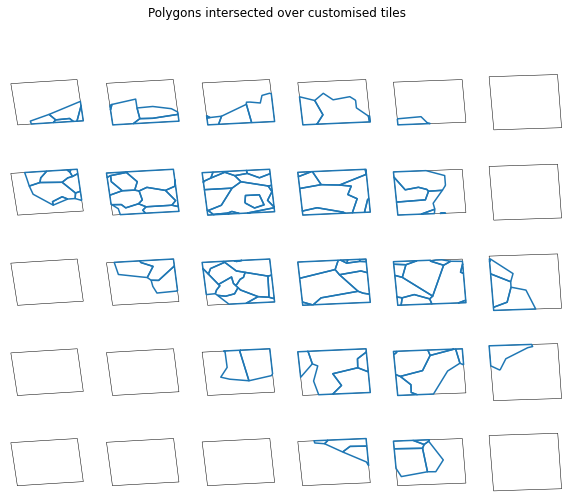

Content of the tile intersection vector layer: [0, 'id', 'geometry', 'NUTS_ID', 'FID', 'URBN_TYPE', 'poly_area', 'LEVL_CODE', 'NAME_LATN', 'NUTS_NAME', 'COAST_TYPE', 'CNTR_CODE', 'MOUNT_TYPE']


In [31]:
def intersect_to_tile(cls, index, tile, polygon):
    mask = gpd.GeoDataFrame([1], geometry=[tile.geometry[index]], crs=tile.crs)
    return gpd.overlay(polygon, mask, how='intersection')
Test.intersect_to_tile = classmethod(intersect_to_tile)

f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)
f.suptitle('Polygons intersected over customised tiles');
for y in range(nytiles):
    for x in range(nxtiles):
        ax[y,x].set_axis_off()
        index = x*nytiles + y
        # inter = Test.intersect_to_tile(index, utiles, polygons)
        onetile = gpd.GeoDataFrame([1], geometry=[utiles.geometry[index]], crs=utiles.crs)
        inter = gpd.overlay(polygons, onetile, how='intersection')
        onetile.boundary.plot(ax=ax[y,x], edgecolor='k', linewidth=0.5)
        if inter.is_empty.all():
            continue
        inter.boundary.plot(ax=ax[y,x])
mplt.show()

print('Content of the tile intersection vector layer: \033[1m%s\033[0m' % list(inter.columns))

Instead, for memory usage, we can use directly the unary union of the grid cells without actually introducing tiles:

Content of the grid intersection vector layer: ['id', 'COAST_TYPE', 'MOUNT_TYPE', 'NAME_LATN', 'CNTR_CODE', 'FID', 'NUTS_ID', 'NUTS_NAME', 'LEVL_CODE', 'URBN_TYPE', 'poly_area', 'geometry']


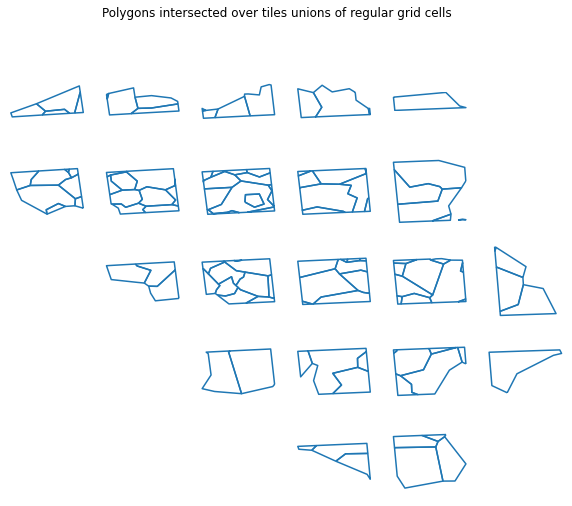

In [32]:
def intersect_to_grid_union(cls, index, grid, polygon):
    # create a single tile object for overlay
    tile = gpd.GeoDataFrame(
        gpd.GeoSeries([grid.iloc[index].unary_union]), 
        columns = ['geometry'], 
        crs = grid.crs
    )
    return gpd.overlay(polygon, tile, how='intersection')
Test.intersect_to_grid_union = classmethod(intersect_to_grid_union)

Test.VERBOSE = True
f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)
f.suptitle('Polygons intersected over tiles unions of regular grid cells')
for y in range(nytiles):
    for x in range(nxtiles):
        ax[y,x].set_axis_off()
        index = Test.get_tile_grid_items(x, y, nrows, ncols, Test.NLIMIT)
        inter = Test.intersect_to_grid_union(index, grid, polygons)
        if inter.is_empty.all():
            continue
        if Test.VERBOSE is True:
            print('Content of the grid intersection vector layer: \033[1m%s\033[0m' % list(inter.columns))
            Test.VERBOSE = False
        inter.boundary.plot(ax=ax[y,x])
mplt.show()

Actually, we will use spatial indexing. Here is an example of what we can do using spatial indexing:

Content of the grid intersection vector layer: ['id', 'COAST_TYPE', 'MOUNT_TYPE', 'NAME_LATN', 'CNTR_CODE', 'FID', 'NUTS_ID', 'NUTS_NAME', 'LEVL_CODE', 'URBN_TYPE', 'geometry', 'poly_area']


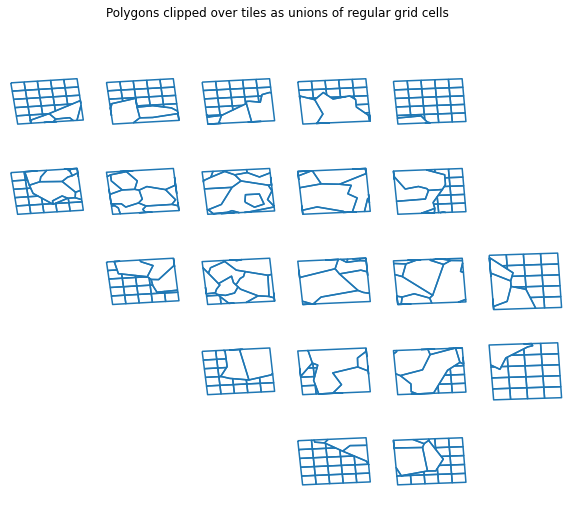

In [33]:
def clip_to_grid_union(cls, index, grid, polygon):
    # create a single tile object for clipping
    union = grid.iloc[index].unary_union
    # env = union.envelope
    # create/retrieve the spatial index
    sindex = polygon.sindex
    # create a box for the initial intersection
    bbox = union.bounds # one/unary geometry only
    # bbox = union.bounds.values.tolist()[0]
    # get a list of id's for all polygons that overlap the tile's bounding box 
    sidx = list(sindex.intersection(bbox))
    if sidx == []:
        return None
    # clip / subset the data
    clipped = polygon.iloc[sidx].copy()
    clipped['geometry'] = clipped.intersection(union)
    # return the clipped layer with no null geometry values
    clipped = clipped[~clipped.is_empty]
    return clipped # [clipped.geometry.notnull()]
Test.clip_to_grid_union = classmethod(clip_to_grid_union)

def fill_into_grid(cls, index, grid, clipped):
    comp = clipped.unary_union
    filled = grid.iloc[index].difference(comp)
    return filled[filled.geometry.notnull()]
Test.fill_into_grid = classmethod(fill_into_grid)
    
Test.VERBOSE = True
f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)
f.suptitle('Polygons clipped over tiles as unions of regular grid cells')
for y in range(nytiles):
    for x in range(nxtiles):
        ax[y,x].set_axis_off()
        index = Test.get_tile_grid_items(x, y, nrows, ncols, Test.NLIMIT)
        inter = Test.clip_to_grid_union(index, grid, polygons)
        if inter is None or inter.is_empty.all():
            continue
        if Test.VERBOSE is True:
            print('Content of the grid intersection vector layer: \033[1m%s\033[0m' % list(inter.columns))
            Test.VERBOSE = False
        inter.boundary.plot(ax=ax[y,x])        
        fill = Test.fill_into_grid(index, grid, inter)
        if not (fill is None or fill.is_empty.all()):
            fill.boundary.plot(ax=ax[y,x])        
mplt.show()

This is finally what we want:

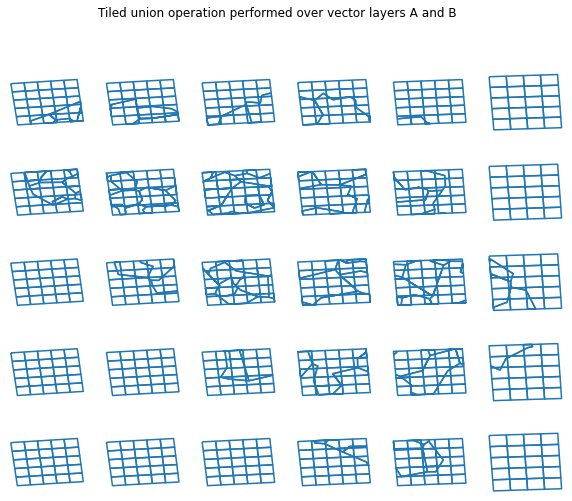

Content of the grid and polygon overlayed union: ['id', 'COAST_TYPE', 'MOUNT_TYPE', 'NAME_LATN', 'CNTR_CODE', 'FID', 'NUTS_ID', 'NUTS_NAME', 'LEVL_CODE', 'URBN_TYPE', 'poly_area', 'geometry', 'pct_area']


In [35]:
def overlay_to_grid_union(cls, index, grid, polygon):
    subgrid = grid.iloc[index]
    union = subgrid.unary_union
    #tile = gpd.GeoDataFrame(gpd.GeoSeries([union]), columns = ['geometry'], crs = grid.crs)
    sindex = polygon.sindex
    bbox = union.bounds # one/unary geometry only
    # bbox = union.bounds.values.tolist()[0]
    sidx = list(sindex.intersection(bbox))
    if sidx == []:
        clipped = subgrid.copy() # copy prevents SettingWithCopyWarning
        clipped[Test.COL_POLY_AREA] = 0 # np.nan # null area 
        return clipped
    clipped = polygon.iloc[sidx].copy() # copy prevents SettingWithCopyWarning 
    clipped['geometry'] = clipped.intersection(union)
    clipped = clipped[~clipped.is_empty] # clipped[clipped.geometry.notnull()]
    if clipped.is_empty.all():
        clipped = subgrid.copy() 
        clipped[Test.COL_POLY_AREA] = 0 
        return clipped
    else:
        return gpd.overlay(clipped, subgrid, how='union')
Test.overlay_to_grid_union = classmethod(overlay_to_grid_union)

overlayed = pd.DataFrame()

f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)
f.suptitle("Tiled union operation performed over vector layers A and B")
for y in range(nytiles):
    for x in range(nxtiles):
        ax[y,x].set_axis_off()
        index = Test.get_tile_grid_items(x, y, nrows, ncols, Test.NLIMIT)
        overlay = Test.overlay_to_grid_union(index, grid, polygons)
        if overlay is None or overlay.is_empty.all():
            continue
        overlay[Test.COL_PCT_AREA] = 100 * overlay.area.div(overlay[Test.COL_POLY_AREA])
        overlayed = pd.concat([overlayed, overlay], axis=0, ignore_index=True)
        # overlayed = pd.concat([overlayed.copy(), overlay], axis=0, ignore_index=True)
        overlay.boundary.plot(ax=ax[y,x])        
mplt.show()

overlayed = gpd.GeoDataFrame(overlayed, crs=grid.crs)
overlayed.loc[~np.isfinite(overlayed[Test.COL_PCT_AREA]), Test.COL_PCT_AREA] = np.nan # 0 

print('Content of the grid and polygon overlayed union: \033[1m%s\033[0m' % list(overlayed.columns))

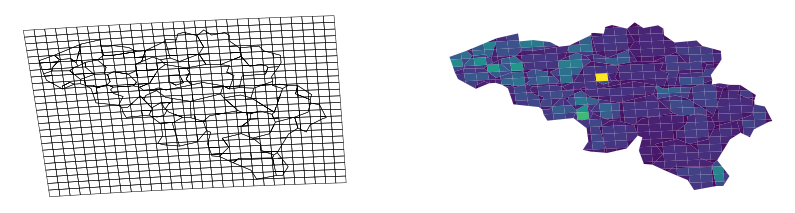

In [36]:
f, ax = mplt.subplots(1,2, figsize=(14,10))
#f.suptitle("Tiled Union operation over vector layers A and B")
overlayed.boundary.plot(ax=ax[0], edgecolor='k', linewidth=0.5)
#ax.set_title('Intersection overlay of one tile with model polygons')

overlayed.plot(column=Test.COL_PCT_AREA, legend=False, ax=ax[1])  
#               legend_kwds={'label': "%age of coverage by model layer", 'orientation': "horizontal"})
ax[0].set_axis_off(); ax[1].set_axis_off()
mplt.show()

### Vector layers overlay: Summary - Algorithm<a id='Algorithm'></a>

**Note: to run the following, you will need to prior run the first two sections of this notebook**.

We assume given (see section on [dummy proxy datasets](#Datasets)):
* a polygon vector representation as the model layer A
* a regular grid layer as the target layer B

like those available at the end of the previous sessions (same reference system here):

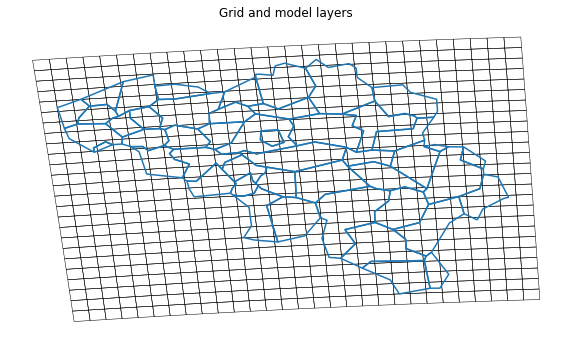

In [37]:
f, ax = mplt.subplots(1, figsize=_FIGSIZE_)
grid.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth=0.5)
polygons.boundary.plot(ax=ax)
ax.set_axis_off(); ax.set_title('Grid and model layers')
mplt.show()

As mentioned earlier, the overlay algorithm consists in the following steps:
* **splitting both layers into tiles**, 
* **performing the "union" set operation for the tiles separately**, 
* **computing areas for the tiles separately**,
* **merging the results**. 

The idea here is to take advantage of:
* **map/reduce approach (*a.k.a* divide-and-conquer),**
* **spatial indexing for optimal joining of vector data.** 
* **parallelisation of the processing.**

We will produce the overlay through parallel tiled processing. Let's first retrieve some information and do some data preparation:

In [38]:
def set_ref_proj(grid, polygons):
    if grid.crs == polygons.crs:
        return None
    else:
        return polygons.to_crs(grid.crs)

def get_shape_info(grid):
    return list(grid.total_bounds)

def get_bbox(grid, polygons, gridbox=True):
    if gridbox is True:
        return get_shape_info(grid)
    elif grid.crs == polygons.crs:
        return polygons.unary_union.union(grid.unary_union).envelope.bounds 
    else:
        return polygons.to_crs(grid.crs).unary_union.union(grid.unary_union).envelope.bounds

# set
polygons = set_ref_proj(polygons, grid) or polygons
bounds = get_bbox(grid, polygons, gridbox=False)
print('Bounding box:', bounds)

Bounding box: (2.334755963599307, 49.26057271004477, 6.672844599945821, 51.69383854241842)


The main parameter is the number/size of tiles we will use to process the data. The decision is actually linked to the actual grid size and their number, which was defined through `NLIMIT` above. 

Different ways to do it:
* the reference grid is defined in a reference system preserving areas (*e.g.*, the `GRIDSIZE` is known, the same for all cells of the grid) and we want to use this information,
* the reference grid dimensions (*e.g.*, `NROWS` and `NCOLS`) are known, and we want to use this information,
* the desired tiling is predefined (*e.g.*, `NXTILES` and `NYTILES`, or the tile size), and we want to use this information.

In [39]:
GRIDSIZE = 0 # gridsize... in meters, works for some reference grid system only... use degrees otherwise
GRIDDEG = (GRIDSIZE * 0.1) / 11000 # very approximate: it depends where you are...
# ...
NROWS, NCOLS = 25, 29
# ...
NYGRID, NXGRID = 5, 5 # dimensions of grid cells in a tile... or else?
# ...
NYTILES, NXTILES = 0, 0 # dimensions of tiles... or else? 
# ...
YTILESIZE, XTILESIZE = 0, 0
# ...

Say we fix the dimension of our grid (`NROWS` and `NCOLS`) and we want to limit the calculation to a given amount of cells (`NXGRID` and `NYGRID`). We use this to define the actual tiling:

In [40]:
GRIDSHAPE = [NROWS, NCOLS] # dimensions of the grid, i.e. number of cell rows and cols
CELLNUM = [NYGRID, NXGRID] # size of a tile, i.e. number of grid cell within one tile

def get_tile_grid_items(x, y, gridshape, cellnum):
    nrows, ncols = gridshape
    nygrid, nxgrid  = cellnum
    index = [(x*nxgrid+i)*nrows + (y*nygrid + j) for j in range(nygrid) for i in range(nxgrid)]
    return [ind for ind in index if ind<=nrows*ncols - 1]

def get_tile_shape(gridshape, cellnum):
    nrows, ncols = gridshape
    nygrid, nxgrid  = cellnum
    return int(np.ceil(nrows / nygrid)), int(np.ceil(ncols / nxgrid))

print("Index of grid cells in first tile (test):", get_tile_grid_items(0, 0, GRIDSHAPE, CELLNUM))
print("Tile dimension (test):", get_tile_shape(GRIDSHAPE, CELLNUM))

Index of grid cells in first tile (test): [0, 25, 50, 75, 100, 1, 26, 51, 76, 101, 2, 27, 52, 77, 102, 3, 28, 53, 78, 103, 4, 29, 54, 79, 104]
Tile dimension (test): (5, 6)


Assuming the input data are given, we retrieve the essential information that was otherwise defined through global variables in the previous exercise.

In [41]:
COL_POLY_AREA = 'poly_area'
COL_PCT_AREA = 'pct_area'
NAN = np.nan if True else 0 #?

We define the set operations that will be run at tile level:

In [42]:
def union_overlay_tile(polygons, grid, index, col_area='area'): 
    # Perform set/geometric intersection/union operations over grid and model/polygon layers 
    # at tile level
    # 1. create a single tile object for clipping
    subgrid = grid.iloc[index]
    # 2. build the dissolved version of the grid (i.e. "merge" the geometries in the subgrid)
    union = subgrid.unary_union
    # 3. create a box for the initial intersection
    bbox = union.bounds # one/unary geometry only
    # 4. retrieve the spatial index - the index can be created outside when calling it the first time
    sindex = polygons.sindex
    # 5. get a list of id's for all polygons that overlap/intersect the subgrid bounding box 
    sidx = list(sindex.intersection(bbox))
    # checking whether the geometries actually overlap/intersect, otherwise return the subgrid
    if sidx == []:
        return subgrid # note that the absence of 'copy' will raise a SettingWithCopyWarning
    # 6. clip / subset the polygon data that intersect
    clipped = polygons.iloc[sidx].copy() # ibid: the presence of 'copy' will prevent a SettingWithCopyWarning
    clipped['geometry'] = clipped.intersection(union)
    # clean by getting rid of empty geometries, possibly returning the subgrid when empty
    clipped = clipped[~clipped.is_empty] 
    if clipped.is_empty.all():
        return subgrid # preserve the subgrid
    # 7. when not empty, retrieve the union of the subgrid with the clipped polygons
    return gpd.overlay(clipped, subgrid, how='union')

def area_overlay_tile(overlay, col_area='area', col_pct='pct_area'):    
    # Update the geometries with the area information
    if col_area not in overlay.columns:
        overlay[col_area] = 0  # null area, will ensure a division /0 and Inf values
    overlay[col_pct] = 100 * overlay.area.div(overlay[col_area])
    return overlay

The tiling can be run sequentially, but this will obviously present little advantage:

In [43]:
def process_one_tile(x, y, polygons, grid, gridshape, cellnum):
    # retrieve the indexes of the grid cells within the considered tile
    index = get_tile_grid_items(x, y, 
                                gridshape, 
                                cellnum)    
    # run the union overlay on a single tile
    overlay = union_overlay_tile(polygons, 
                                 grid, 
                                 index, 
                                 COL_POLY_AREA)
    if overlay is None or overlay.is_empty.all():
        return None
    # compute the percentage of area covered by the input model layer
    return area_overlay_tile(overlay, 
                             COL_POLY_AREA, 
                             COL_PCT_AREA)

def process_tile_serial(polygons, grid, gridshape, cellnum, display=False):
    # Process the tiles sequentially
    nytiles, nxtiles = get_tile_shape(gridshape, 
                                      cellnum)
    if display:
        f, ax = mplt.subplots(nytiles, nxtiles, figsize=_FIGSIZE_)
        f.suptitle("Tiled representation")
    overlayed = pd.DataFrame()
    for y in range(nytiles):
        for x in range(nxtiles):
            if display: 
                ax[y,x].set_axis_off()
            overlay = process_one_tile(x, y, 
                                       polygons, 
                                       grid, 
                                       gridshape, 
                                       cellnum)
            if overlay is None:
                continue
            # simply join/concat the various tiled areas since they do not overlap
            overlayed = pd.concat([overlayed, overlay], 
                                  axis=0, ignore_index=True)
            if display: 
                overlay.boundary.plot(ax=ax[y,x])
    if display: mplt.show()
    overlayed = gpd.GeoDataFrame(overlayed, crs=grid.crs)
    overlayed.loc[~np.isfinite(overlayed[COL_PCT_AREA]), COL_PCT_AREA] = NAN
    return overlayed

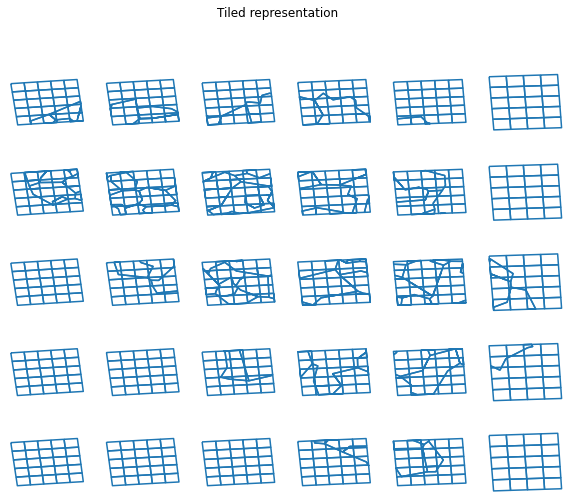

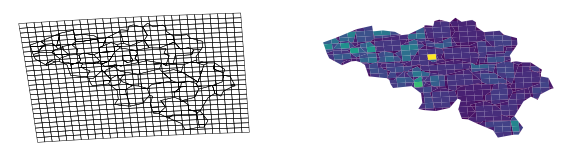

In [44]:
pd.set_option('mode.chained_assignment', None) # ignore clearly identified SettingWithCopyWarning)

# compute the area and assign to some attribute 
polygons[COL_POLY_AREA] = polygons.area
# already force the calculation of the spatial index
grid.sindex

_TILE_DISPLAY_ = True
overlayed = process_tile_serial(polygons, grid, GRIDSHAPE, CELLNUM, display=_TILE_DISPLAY_)

f, ax = mplt.subplots(1,2, figsize=_FIGSIZE_)
# f.suptitle("Overlay representation and percentage area")
overlayed.boundary.plot(ax=ax[0], edgecolor='k', linewidth=0.5)
overlayed.plot(column=COL_PCT_AREA, legend=False, ax=ax[1])  
ax[0].set_axis_off(); ax[1].set_axis_off()
mplt.show()

Instead we introduce multi(parallel) processing capabilities for solving this problem:

In [45]:
def process_tile_multi(nproc, polygons, grid, gridshape, cellnum):
    nytiles, nxtiles = get_tile_shape(gridshape, 
                                      cellnum)
    pool = mp.Pool(processes=nproc)
    overlay_tile = [pool.apply_async(process_one_tile,
                                     args = (x, y,
                                             polygons,
                                             grid, 
                                             gridshape, 
                                             cellnum))
                    for y in range(nytiles) for x in range(nxtiles)]
    pool.close()
    pool.join()
    overlayed = pd.concat([t.get() for t in overlay_tile], 
                          axis=0, ignore_index=True)
    overlayed = gpd.GeoDataFrame(overlayed, crs=grid.crs)
    overlayed.loc[~np.isfinite(overlayed[COL_PCT_AREA]), COL_PCT_AREA] = NAN
    return overlayed

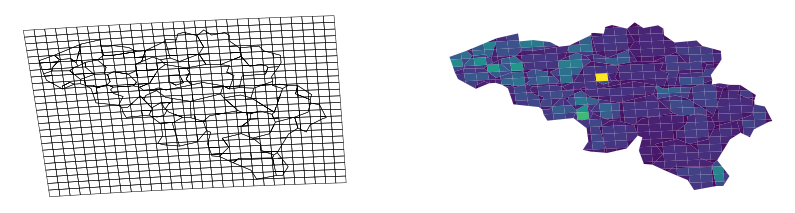

In [46]:
# already done above in the serial processing approach:
# pd.set_option('mode.chained_assignment', None)
# polygons[COL_POLY_AREA] = polygons.area

#%timeit 
overlayed = process_tile_multi(mp.cpu_count(), polygons, grid, GRIDSHAPE, CELLNUM)

f, ax = mplt.subplots(1,2, figsize=(14,10))
# f.supttle("Overlay representation and percentage area")
overlayed.boundary.plot(ax=ax[0], edgecolor='k', linewidth=0.5)
overlayed.plot(column=COL_PCT_AREA, legend=False, ax=ax[1])  
ax[0].set_axis_off(); ax[1].set_axis_off()
mplt.show()

Another approach using callback:

In [47]:
overlayed = pd.DataFrame()
def concat_overlay(overlay):
    overlayed = pd.concat([overlayed, overlay],
                          axis=0, 
                          ignore_index=True)

if __name__ == '__main__':
    break
    pool = mp.Pool(processes=mp.cpu_count())
                                 
    nytiles, nxtiles = get_tile_shape(GRIDSHAPE, 
                                      CELLNUM)
    overlay_tile = [pool.apply_async(process_one_tile,
                                     args = (x, y,
                                             polygons,
                                             grid, 
                                             GRIDSHAPE, 
                                             CELLNUM),
                                    callback = concat_overlay)#.wait()
                    for y in range(nytiles) for x in range(nxtiles)]
    pool.close()
    pool.join() 
    
    overlayed = gpd.GeoDataFrame(overlayed, crs=grid.crs)
    overlayed.loc[~np.isfinite(overlayed[COL_PCT_AREA]), COL_PCT_AREA] = NAN

    f, ax = mplt.subplots(1,2, figsize=(14,10))
    # f.suptitle("Overlay representation and percentage area")
    overlayed.boundary.plot(ax=ax[0], edgecolor='k', linewidth=0.5)
    overlayed.plot(column=COL_PCT_AREA, legend=False, ax=ax[1])  
    ax[0].set_axis_off(); ax[1].set_axis_off()
    mplt.show()

SyntaxError: 'break' outside loop (<ipython-input-47-b2968246a441>, line 11)

### Alternative solution - Rasterisation<a id='Rasterisation'></a>

This is actually a coarse approximation since you will get a unique polygon ID per grid cell. The quality/accuracy of the approximation however improves with an increased resolution.